In [1]:
import numpy as np
import mdtraj as md
from pathlib import Path
from md_traj_utils import clean_traj, clean_traj_c_alpha, best_hummer_q

In [2]:
INTERESTING_DESHAW_PROTEINS = {"Villin": {"Start1":1,"folded_PDB": "2F4K", "Abbreviation":"2F4K","Mutations":[23,26,28],"Experiment_mutations":[25]},"Protein_G": {"Start1":5,"folded_PDB": "1MI0", "Abbreviation":"NuG2","Start":5,"Mutations":[41]},"NTL9": {"folded_PDB": "2hba", "Abbreviation":"NTL9", "Length": 37,"Mutations":[11]},}

for protein_name, protein_info in INTERESTING_DESHAW_PROTEINS.items():
    print(f"Working on {protein_name}")
    protein_stub = Path("/data/jgut/msa-tests/deshaw_ovchinnikov")/protein_name
    folded_path = protein_stub/"folded.pdb"
    experimental = md.load_pdb(folded_path)
    experimental = experimental.atom_slice(experimental.topology.select('chainid == 0 and protein and symbol != H and name != OXT'))
    start = 0
    if "Start" in protein_info:
        start = protein_info["Start"]
        experimental = experimental.atom_slice(experimental.topology.select(f'resid {start} to 100000000'))
    if "Length" in protein_info:
        experimental = experimental.atom_slice(experimental.topology.select(f'resid 0 to {protein_info["Length"]}'))
    if "Experiment_mutations" in protein_info:
        mutations = protein_info["Experiment_mutations"] 
        selection_string = f'resid != {mutations[0]-start}'
        experimental = experimental.atom_slice(experimental.topology.select(selection_string))
        for it, further_mutation in enumerate(mutations[1:]):
            selection_string = f'resid != {further_mutation-start}'
            experimental = experimental.atom_slice(experimental.topology.select(selection_string)) 
    elif "Mutations" in protein_info:
        mutations = protein_info["Mutations"] 
        selection_string = f'resid != {mutations[0]-start}'
        experimental = experimental.atom_slice(experimental.topology.select(selection_string))
        for it, further_mutation in enumerate(mutations[1:]):
            selection_string = f'resid != {further_mutation-start}'
            experimental = experimental.atom_slice(experimental.topology.select(selection_string)) 
            experimental = experimental.center_coordinates()
    pred_path = list((protein_stub/"normal").glob("*_rank_001_alphafold2*pdb"))[0]
    pred_traj = md.load_pdb(pred_path)
    if "Start1" in protein_info:
        start = protein_info["Start1"]
        pred_traj = pred_traj.atom_slice(pred_traj.topology.select(f'resid {start} to 100000000'))
        if protein_name=="Villin":
            start = 0
    if "Length" in protein_info:
        pred_traj = pred_traj.atom_slice(pred_traj.topology.select(f'resid 0 to {protein_info["Length"]}'))
    if "Mutations" in protein_info:
        mutations = protein_info["Mutations"] 
        selection_string = f'resid != {mutations[0]-start}'
        pred_traj = pred_traj.atom_slice(pred_traj.topology.select(selection_string))
        for it, further_mutation in enumerate(mutations[1:]):
            selection_string = f'resid != {further_mutation-start-it-1}'
            pred_traj = pred_traj.atom_slice(pred_traj.topology.select(selection_string))
    pred_traj = pred_traj.superpose(experimental).center_coordinates()
    pred_qs = best_hummer_q(pred_traj, experimental)
    print(f"The Q-score {protein_name} between experiment and MMseqs prediction is {pred_qs}")

Working on Villin
hey
Number of native contacts 217
The Q-score Villin between experiment and MMseqs prediction is [0.85916525]
Working on Protein_G
hey
Number of native contacts 687
The Q-score Protein_G between experiment and MMseqs prediction is [0.8035345]
Working on NTL9
Number of native contacts 448
The Q-score NTL9 between experiment and MMseqs prediction is [0.8471741]


/tmp/ipykernel_3620749/2136208788.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


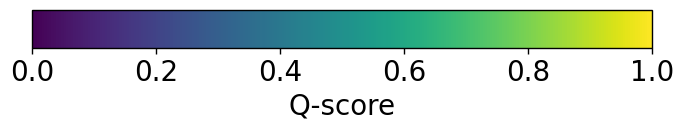

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a vertical color scale (colorbar) from 0 to 1
fig, ax = plt.subplots(figsize=(8, 0.5))

# Create a scalar mappable for the viridis colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

# Create and add the colorbar
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal'
)

# Invert the color scale so that 1 is at the top and 0 at the bottom
cb.ax.invert_yaxis()

# Make ticks and tick marks thicker
cb.ax.tick_params(
    width=1,          # thickness of tick marks
    length=4,         # length of tick marks
    labelsize=20      # size of tick labels
)

# Add the vertical title (label)
cb.set_label('Q-score', rotation=0, fontsize=20)

# Thicken the colorbar outline
for spine in cb.ax.spines.values():
    spine.set_linewidth(1)
plt.tight_layout()
plt.savefig("visualisations/colourbar.pdf", format="pdf", dpi=600, transparent=True,bbox_inches='tight')
plt.show()